In [2]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16, 6)  # make the default figure size larger
matplotlib.rcParams['image.interpolation'] = 'nearest'  # don't blur/smooth image plots
from matplotlib import pyplot as plt
import webbpsf
import webbpsf.wfirst

The next cell tells WebbPSF to log information about what it is doing so that we can watch the progress of the calculation:

In [3]:
webbpsf.setup_logging()

WebbPSF log messages of level INFO and above will be shown.
WebbPSF log outputs will be directed to the screen.


**Note:** As you explore in this notebook, you may see certain warnings that look like this:

<div class="output_subarea output_stderr" style="font-family: monospace; margin: 1em">Warning: something happened! </div>

For the most part, warnings are safe to ignore. In particular, warnings referencing the matplotlib plotting library or the FITS library in Astropy don't indicate anything that could affect the accuracy of the calculations.

# Using the WFI model in WebbPSF

Each instrument in WebbPSF is represented as a Python `class`, and the Wide Field Instrument model is in `webbpsf.wfirst.WFI`. We need to instantiate one to work with:

In [4]:
wfi = webbpsf.wfirst.WFI()

## Using the notebook interface

There's a notebook-friendly interface for the Wide Field Instrument PSF model. Bring it up in your notebook by running the following cell, then experiment with the different options, or read on for more explanation.

In [ ]:
webbpsf.jupyter_gui.show_notebook_interface_wfi(wfi)

### Calculate PSF

When you click the "Calculate PSF" button, you will see some output as the calculation progresses. When it completes, it will show a plot showing three panels (counting left-to-right) representing the optical planes in the model:

  1. The entrance pupil transmission in black and white, and the phase ranging from red to blue to show the wavefront error. We include here a plausible estimate for wavefront error due to mirror polishing variations. (This is currently approximated by a map of high-frequency errors in the Hubble primary, since such data is not yet available for the WFIRST primary mirror.)
  2. The same transmission and phase map with the addition of the phase term due to field-dependent optical aberrations and intermediate instrument optics. (Specifically, this is based on Zernike coefficients derived from the Cycle 5 optical modeling effort at GSFC.)
  3. The final oversampled detector plane, with log-scaled intensity

Below that, you will see a side-by-side comparison of the oversampled PSF, and the PSF binned down to detector pixels.

Also, a button labeled "Download FITS image from last calculation" will appear below the "Calculate PSF" button. Click that to download the oversampled and detector-pixel-binned images as a multi-extension FITS file. (WebbPSF also offers tools to analyze PSFs within the notebook or your own scripts, which are described in the next section.)

### Display Optical System

This shows a 2 x 2 grid of plots. The left hand side shows transmission (e.g. pupil or mask shape), and the right side shows optical path difference (which is converted to phase across the pupil). The first row represents the pupil plane at the primary mirror, and the second row is the notional pupil plane after all the field dependent aberrations have been applied to the wavefront, but before the final propagation to a detector or image plane.

### Clear Output

The output from the calculation process can be pretty verbose, so this button is here to clear both text output and plots.

## Using the Python programming interface

Alternatively, you can configure the WFI instance yourself in Python. A more detailed example is presented in the [WebbPSF-WFIRST documentation page](https://pythonhosted.org/webbpsf/wfirst.html), but here we will just show a simple monochromatic calculation at the default field position.

The `wfi.calcPSF()` method returns a [FITS HDUList object](http://docs.astropy.org/en/stable/io/fits/index.html), which you can then write out to a file or analyze further in the notebook.

[  poppy] Monochromatic calculation requested.
[webbpsf] Using the unmasked WFI pupil shape based on wavelengths requested
[  poppy] PSF calc using fov_arcsec = 5.000000, oversample = 4, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: WFIRST+WFI
[  poppy] WFIRST Entrance Pupil: Loaded amplitude transmission from /Users/rgeda/project/data/webbpsf-data/WFIRST_SRR_WFC_Pupil_Mask_Shortwave_2048.fits
[  poppy] WFIRST Entrance Pupil: Loaded OPD from /Users/rgeda/project/data/webbpsf-data/upscaled_HST_OPD.fits
[  poppy] Added pupil plane: WFIRST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] Added pupil plane: Field Dependent Aberration (SCA01)
[  poppy] Added detector with pixelscale=0.11 and oversampling=4: WFI detector
[  poppy] Calculating PSF with 1 wavelengths
[  poppy]  Propagating wavelength = 1.2e-06 m
[  poppy]   Calculation completed in 13.277 s
[  poppy] PSF Calculation completed.
[  poppy

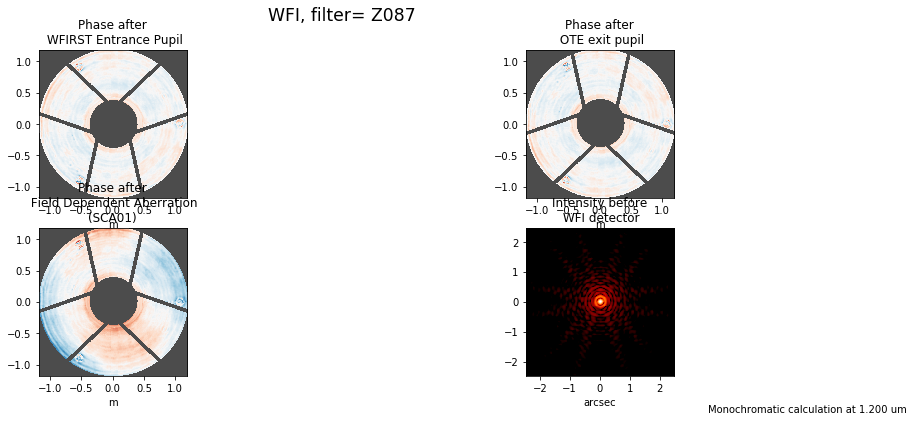

In [5]:
mono_psf = wfi.calcPSF(monochromatic=1.2e-6, display=True)

Now you have the calculation result in the `mono_psf` variable, and can use various utility functions in WebbPSF to analyze it. The FITS object has an extension called `OVERSAMP` with each pixel split according to the default oversampling factor (4), and an extension called `DET_SAMP` with that image binned down to detector pixels.

In [6]:
mono_psf.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU      48   (180, 180)   float64   
  1  DET_SAMP      1 ImageHDU        50   (45, 45)   float64   


Let's plot the PSF in detector pixels:

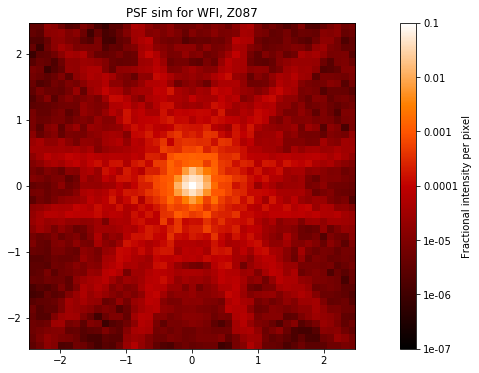

In [7]:
webbpsf.display_PSF(mono_psf, ext='DET_SAMP')

WebbPSF also includes functions for measuring EE, profiles, and centroids (described in the [WebbPSF documentation](http://pythonhosted.org/webbpsf/api_reference.html#functions) and the [POPPY documentation](http://pythonhosted.org/poppy/api.html#functions)). Below we measure the radial profile and encircled energy curve for the monochromatic PSF. (Note that the FWHM is also computed and labeled on the radial profile plot.)

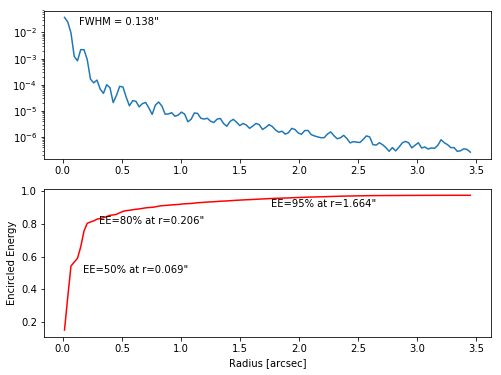

In [8]:
plt.figure(figsize=(8, 6))
webbpsf.display_profiles(mono_psf)

If you want, the FITS object containing the PSF can be written out to a file and downloaded to your computer. This can be useful if you need it as an input to another tool.

In [9]:
mono_psf.writeto('./mono_psf_1.2um.fits', clobber=True)

[astropy] AstropyDeprecationWarning: "clobber" was deprecated in version 2.0 and will be removed in a future version. Use argument "overwrite" instead.


After you run the previous cell, this link will take you to download the FITS image: <a href="files/mono_psf_1.2um.fits">Download mono_psf_1.2um.fits</a>

How that works is a little tricky: when you write `./mono_psf_1.2um.fits`, you're saying you want to save the file in the current working directory for the *Python* process. If you're working locally, that's just the directory where you started the `jupyter notebook` command. If you're working on a remote server, files saved from the notebook will be available at the URL `files/your_filename.fits` relative to this page.

For example, if you're viewing this notebook at `https://example.com/user/janedoe/notebooks/WebbPSF-WFIRST_Tutorial.ipynb`, your file will be at `https://example.com/user/janedoe/notebooks/`**files/mono_psf_1.2um.fits**.

# What next?

Keep working in this notebook, if you like! For reference, there's always a [pristine copy of this notebook](https://github.com/spacetelescope/webbpsf/blob/master/notebooks/WebbPSF-WFIRST_Tutorial.ipynb) to refer back to in the  [WebbPSF GitHub repository](https://github.com/spacetelescope/webbpsf).  If you have not previously used this notebook interface to Python, the Help menu available above has a tutorial and a useful list of keyboard shortcuts. 

  * **Review the [WebbPSF documentation](https://pythonhosted.org/webbpsf/) and the [POPPY documentation](https://pythonhosted.org/poppy/)**
  * **Report any issues to us on GitHub** — 
    WebbPSF and POPPY are developed on GitHub: [mperrin/webbpsf](https://github.com/spacetelescope/webbpsf) and [mperrin/poppy](https://github.com/spacetelescope/poppy) respectively.
    The best way to report bugs is through the GitHub issue trackers: [WebbPSF](https://github.com/spacetelescope/webbpsf/issues) or [POPPY](https://github.com/spacetelescope/poppy/issues). (We also welcome pull requests from the community, if there's functionality you think should be included!)
  * **Contact us through the STScI helpdesk** — You can always email your questions to <a href="mailto:help@stsci.edu">help@stsci.edu</a>, and our helpdesk people will make sure your request gets to the right person
  * **Sign up for WebbPSF update announcements** —
    This is entirely optional, but you may wish to sign up to the mailing list webbpsf-users@stsci.edu. This is a low-traffic moderated announce-only list, to which we will periodically post announcements of updates to this software. To subscribe, visit the [maillist.stsci.edu](http://maillist.stsci.edu) server